<a href="https://colab.research.google.com/github/wodamba-alt/Bottle-fill-yollo-11-training/blob/main/Training_with_R_CNN_on_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FINETUNING A R-CNN with ResNet backbone for object detection of COCOCOLA BOTTLES

In [1]:
!pip install roboflow
!pip install fiftyone
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="O466H8chxDAKF7O5Yuil")
project = rf.workspace("davidbottle-defect-inspection").project("bottle-fill-level-and-cap-detec")
version = project.version(9)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bottle-fill-level-and-cap-detec-9 in coco:: 100%|██████████| 816/816 [00:00<00:00, 2579.84it/s]


In [3]:
import os
import torch
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
import numpy as np

# Define paths
dataset_path = dataset.location
ann_file = os.path.join(dataset_path, "/content/bottle-fill-level-and-cap-detec-9/train/_annotations.coco.json")
img_dir = os.path.join(dataset_path, "/content/bottle-fill-level-and-cap-detec-9/train")

# Define transforms
transform = T.Compose([
    T.ToTensor(),
])

# Load dataset
full_dataset = CocoDetection(img_dir, ann_file, transform=transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(project.classes) + 1  # +1 for background

# Replace head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 91.4MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
import torch.optim as optim
from tqdm import tqdm

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 100
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        formatted_targets = []
        for i, t in enumerate(targets):
            boxes = torch.tensor([obj["bbox"] for obj in t], dtype=torch.float32)
            boxes[:, 2:] += boxes[:, :2]  # Convert [x, y, w, h] to [x1, y1, x2, y2]
            labels = torch.tensor([obj["category_id"] for obj in t], dtype=torch.int64)
            formatted_targets.append({"boxes": boxes.to(device), "labels": labels.to(device)})

        loss_dict = model(images, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


100%|██████████| 226/226 [01:22<00:00,  2.74it/s]


Epoch 1/100, Loss: 27.0131


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 2/100, Loss: 15.7691


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 3/100, Loss: 12.2604


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 4/100, Loss: 8.4439


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 5/100, Loss: 7.6625


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 6/100, Loss: 7.4109


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 7/100, Loss: 7.0491


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 8/100, Loss: 6.8755


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 9/100, Loss: 6.8783


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 10/100, Loss: 6.8058


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 11/100, Loss: 6.7412


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 12/100, Loss: 6.7941


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 13/100, Loss: 6.7753


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 14/100, Loss: 6.7188


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 15/100, Loss: 6.8079


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 16/100, Loss: 6.7601


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 17/100, Loss: 6.8465


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 18/100, Loss: 6.8253


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 19/100, Loss: 6.7842


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 20/100, Loss: 6.7555


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 21/100, Loss: 6.7643


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 22/100, Loss: 6.7947


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 23/100, Loss: 6.8001


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 24/100, Loss: 6.7857


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 25/100, Loss: 6.8224


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 26/100, Loss: 6.8014


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 27/100, Loss: 6.7914


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 28/100, Loss: 6.8319


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 29/100, Loss: 6.7338


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 30/100, Loss: 6.8005


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 31/100, Loss: 6.7966


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 32/100, Loss: 6.7653


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 33/100, Loss: 6.8406


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 34/100, Loss: 6.7690


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 35/100, Loss: 6.8114


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 36/100, Loss: 6.7945


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 37/100, Loss: 6.7745


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 38/100, Loss: 6.7543


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 39/100, Loss: 6.7868


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 40/100, Loss: 6.7939


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 41/100, Loss: 6.8368


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 42/100, Loss: 6.7786


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 43/100, Loss: 6.7763


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 44/100, Loss: 6.7687


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 45/100, Loss: 6.8162


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 46/100, Loss: 6.7354


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 47/100, Loss: 6.7841


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 48/100, Loss: 6.7701


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 49/100, Loss: 6.7996


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 50/100, Loss: 6.7322


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 51/100, Loss: 6.7460


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 52/100, Loss: 6.8356


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 53/100, Loss: 6.8156


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 54/100, Loss: 6.8356


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 55/100, Loss: 6.7479


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 56/100, Loss: 6.8176


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 57/100, Loss: 6.7485


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 58/100, Loss: 6.8657


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 59/100, Loss: 6.7821


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 60/100, Loss: 6.7784


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 61/100, Loss: 6.8351


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 62/100, Loss: 6.7633


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 63/100, Loss: 6.7774


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 64/100, Loss: 6.8366


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 65/100, Loss: 6.7972


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 66/100, Loss: 6.7742


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 67/100, Loss: 6.7553


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 68/100, Loss: 6.7727


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 69/100, Loss: 6.8041


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 70/100, Loss: 6.7287


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 71/100, Loss: 6.7922


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 72/100, Loss: 6.8351


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]


Epoch 73/100, Loss: 6.7582


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 74/100, Loss: 6.7861


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 75/100, Loss: 6.8127


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 76/100, Loss: 6.7325


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 77/100, Loss: 6.7205


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 78/100, Loss: 6.7656


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 79/100, Loss: 6.8482


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 80/100, Loss: 6.7992


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 81/100, Loss: 6.8685


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 82/100, Loss: 6.7549


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 83/100, Loss: 6.7913


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 84/100, Loss: 6.7985


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 85/100, Loss: 6.7906


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 86/100, Loss: 6.7666


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 87/100, Loss: 6.7432


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 88/100, Loss: 6.7229


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 89/100, Loss: 6.7829


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 90/100, Loss: 6.7750


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 91/100, Loss: 6.8087


100%|██████████| 226/226 [01:22<00:00,  2.76it/s]


Epoch 92/100, Loss: 6.7984


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 93/100, Loss: 6.8070


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 94/100, Loss: 6.7680


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 95/100, Loss: 6.8109


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 96/100, Loss: 6.7925


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 97/100, Loss: 6.6955


100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch 98/100, Loss: 6.8597


100%|██████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch 99/100, Loss: 6.7433


100%|██████████| 226/226 [01:21<00:00,  2.77it/s]

Epoch 100/100, Loss: 6.8568


In [7]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first element
            # of true_labels if it has more elements than pred_labels
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Confusion Matrix and Metrics
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))
print("Precision:", precision_score(all_targets, all_preds, average='macro'))
print("Recall:", recall_score(all_targets, all_preds, average='macro'))
print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
print("Accuracy:", accuracy_score(all_targets, all_preds))

100%|██████████| 114/114 [00:11<00:00, 10.18it/s]


Confusion Matrix:
 [[40  0  1  0  1]
 [ 0 28  0  7  0]
 [ 1  0 26 12  0]
 [ 0  7 12 46  7]
 [ 1  0  0  7 32]]
Precision: 0.7715873015873015
Recall: 0.7715873015873015
F1 Score: 0.7715873015873015
Accuracy: 0.7543859649122807


100%|██████████| 114/114 [00:10<00:00, 10.44it/s]


Confusion Matrix:
 [[40  0  1  0  1]
 [ 0 28  0  7  0]
 [ 1  0 26 12  0]
 [ 0  7 12 46  7]
 [ 1  0  0  7 32]]
Precision: 0.7716
Recall:    0.7716
F1 Score:  0.7716
Accuracy:  0.7544


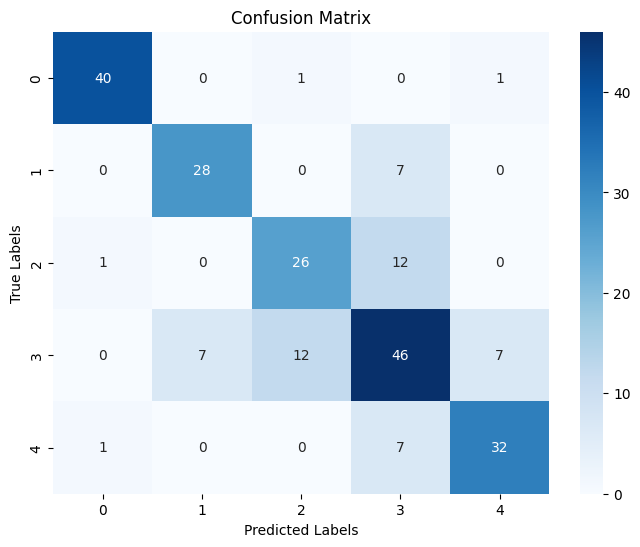

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            # Extract true labels from the list of dictionaries
            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first elements
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Compute confusion matrix and metrics
cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
